<a href="https://colab.research.google.com/github/krajak09/Master-Thesis/blob/main/Time_series_gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# This will print out the downloaded path
path = kagglehub.dataset_download("angelvarela/gold-data-to-predict-the-stock-market")
print("Downloaded files:", path)

import os
print(os.listdir(path))  # List all files in the dataset folder


Downloaded files: /kaggle/input/gold-data-to-predict-the-stock-market
['Achilles_Data-Gold-Silver.csv', 'Achilles_Data-Gold.csv']


In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Achilles_Data-Gold.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "angelvarela/gold-data-to-predict-the-stock-market",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

# I got this code from kaggle

/tmp/ipython-input-1320508199.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:          time     open     high      low    close  tick_volume          ema  \
0  1672707720  1826.92  1827.65  1826.92  1827.24           47  2166.827022   
1  1672707780  1827.26  1827.86  1827.18  1827.84           36  2166.827022   
2  1672707840  1827.83  1828.70  1827.83  1828.66           47  2166.827022   
3  1672707900  1828.65  1829.92  1828.62  1829.80           65  2166.827022   
4  1672707960  1829.84  1830.94  1829.84  1830.63           87  2166.827022   

     obv  
0   47.0  
1   83.0  
2  130.0  
3  195.0  
4  282.0  


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# convert UNIX timestamp to datetime
df['time'] = pd.to_datetime(df['time'], unit = 's')

# sort by time and set as index
df = df.sort_values('time')
df.set_index('time', inplace=True)

# plot
plt.figure(figsize=(12,6))
plt.plot(df['open'], label='Open Price')
plt.title('Gold Open Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# converted time from seconds into datetime, sorted and set the datetime as the index and plotted the open price as a graph

NameError: name 'df' is not defined

In [ ]:
# number of rows -> datapoints, replace 0 with 1 for number of columns
df.shape[0]


708264

In [ ]:
!pip install filterpy

In [ ]:
import numpy as np

from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise # another filterpy library function

from scipy.optimize import minimize
import scipy.stats as stats

In [ ]:
df['open'].values[0]

np.float64(1826.92)

In [ ]:
stats.lognorm.pdf(0,1, loc=1,scale=1)

np.float64(0.0)

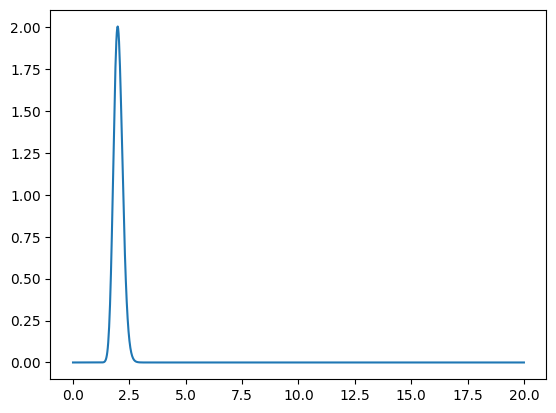

In [ ]:
xs = np.linspace(0,20,1000)
ys = [stats.lognorm.pdf(x,0.1,0,2) for x in xs]
plt.plot(xs,ys)

In [ ]:
def r_prior(r):
  log_p = stats.lognorm.logpdf(r,0.1,0,2)
  return log_p #retrun log p(r)

def q_prior(q):
  return 0.0 # return log p(q)

In [ ]:
# perform a standard predict/update loop

ys = df['open'].values # not in the loop since I don't want to optimize the data
ys_sub = ys[0:1000]

def energy_function(theta):
  log_q = theta[0]
  log_r = theta[1]
  q = np.exp(log_q) # process noise variance
  r = np.exp(log_r) # measurement noise variance

  f = KalmanFilter(dim_x=2, dim_z=1)

  f.x = np.array([ys_sub[0], 0.]) # initial value for the state
  f.P = np.array([[100,    0.],
                  [   0., 100] ]) # covariance matrix for initial state


  f.F = np.array([[1.,1.],
                  [0.,1.]]) # state transition matrix

  f.H = np.array([[1.,0.]]) # measurement function


  f.R = np.array([[r]]) # measurement noise

  f.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=q) # creates specific process noise covariance for a constant-aceleration model

  score = 0

  score += q_prior(q)
  score += r_prior(r)

  for y in ys_sub:
    f.predict() # predict next step and covariance
    f.update(y) # update with measurement

    # v = f.y[0] # scalar residual
    # S = f.S[0][0] # scalar innovation covariance
    # log_likelihood = f.log_likelihood = -0.5 * (np.log(2*np.pi*S)+v**2/S)

    score += f.log_likelihood # accumulate the negative log-likelihood
  return -score

In [ ]:
# more general approach using closures
def make_energy_function(H,F,...)
  def energy_function(theta):
    ...
    #with free H,F ect.
    return -score

  return energy_function

#usage
my_energy_function = make_energy_function(H,F...)

my_enery_function(theta)

In [ ]:
theta0 = np.array([1.0,10.0])
%time energy_function(theta0)

CPU times: user 215 ms, sys: 923 µs, total: 216 ms
Wall time: 217 ms


np.float64(10283.717866276093)

In [ ]:
theta0 = np.log([1,10.0]) # initial guess for q and r
res = minimize(energy_function, theta0, method='Nelder-Mead')

q_opt, r_opt = np.exp(res.x)
nit, nfev = res.nit, res.nfev
print("Optimal process noise q:", q_opt)
print("Optimal measurement noise r:", r_opt)
print("Did", nfev, "function evaluations in", nit, "iterations.")

Optimal process noise q: 1.3118337184325464
Optimal measurement noise r: 0.32506348317608674
Did 128 function evaluations in 65 iterations.


In [2]:
def run_kalman(theta):
  log_q = theta[0]
  log_r = theta[1]
  q = np.exp(log_q) # process noise variance
  r = np.exp(log_r) # measurement noise variance

  f = KalmanFilter(dim_x=2, dim_z=1)

  f.x = np.array([ys_sub[0], 0.]) # initial value for the state
  f.P = np.array([[100,    0.],
                  [   0., 100] ]) # covariance matrix for initial state


  f.F = np.array([[1.,1.],
                  [0.,1.]]) # state transition matrix

  f.H = np.array([[1.,0.]]) # measurement function


  f.R = np.array([[r]]) # measurement noise

  f.Q = np.array([[0.,0.],
                  [0.,0.]]
  # Q_discrete_white_noise(dim=2, dt=0.1, var=q) # creates specific process noise covariance for a constant-aceleration model

  score = 0

  filtered = []

  for y in ys_sub:
    f.predict()
    f.update(y)
    filtered.append(f.x[0]) # estimated position

  return filtered

In [ ]:
theta_opt=np.array([q_opt, r_opt])
filtered_opt = run_kalman(theta_opt)

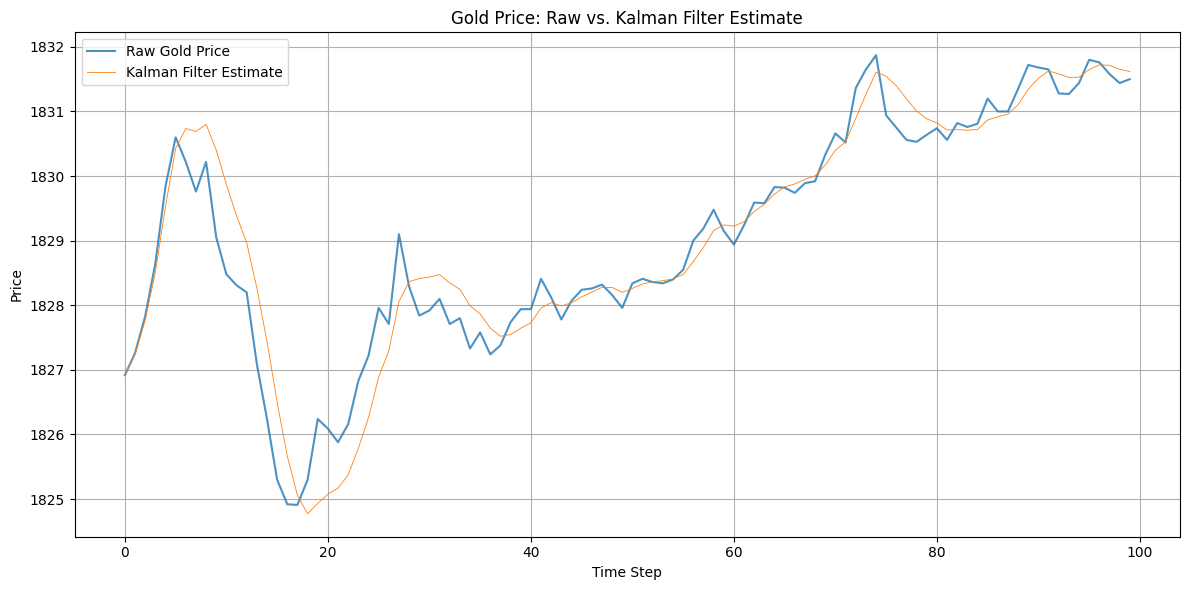

In [ ]:
# plot
plt.figure(figsize=(12,6))
plt.plot(ys_sub, label='Raw Gold Price', alpha=0.8)
plt.plot(filtered_opt, label='Kalman Filter Estimate', linewidth=0.6)
plt.legend()
plt.title("Gold Price: Raw vs. Kalman Filter Estimate")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
f = KalmanFilter(dim_x=2, dim_z=1)

f.x = np.array([2., 0.]) # initial value for the state

f.F = np.array([[1.,1.],
                  [0.,1.]]) # state transition matrix

f.H = np.array([[1.,0.]]) # measurement function

f.P = np.array([[100.,    0.],
                  [   0., 100.] ]) # covariance matrix

f.R = np.array([[r_opt]]) # using optimized r

f.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=q_opt) # using optimized q

filtered = []

for y in ys:
  f.predict()
  f.update(y)
  filtered.append(f.x[0]) # estimated position



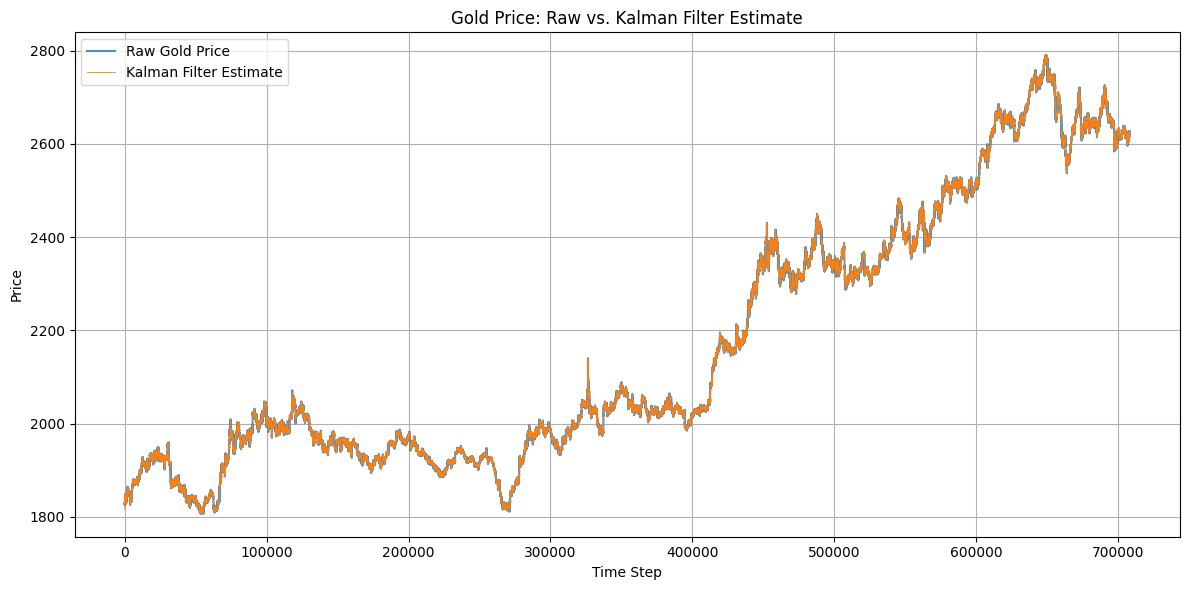

In [ ]:
# plot for all ys
plt.figure(figsize=(12,6))
plt.plot(ys, label='Raw Gold Price', alpha=0.8)
plt.plot(filtered, label='Kalman Filter Estimate', linewidth=0.6)
plt.legend()
plt.title("Gold Price: Raw vs. Kalman Filter Estimate")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
%time filter(ys_sub)

CPU times: user 449 ms, sys: 0 ns, total: 449 ms
Wall time: 450 ms


[array([2., 0.]),
 array([1220.63428571,  606.28571429]),
 array([1827.14741722,  606.39942289]),
 array([2052.35742721,  452.72617977]),
 array([2118.58177483,  325.14045223]),
 array([2126.12078999,  235.67435551]),
 array([2110.44404919,  172.68730483]),
 array([2084.23867986,  126.65200656]),
 array([2053.07962466,   91.84219508]),
 array([2020.17461543,   64.99631585]),
 array([1986.66788545,   43.99459381]),
 array([1954.40275732,   27.74903918]),
 array([1924.790899  ,   15.49620324]),
 array([1898.75362582,    6.59392575]),
 array([1.87643575e+03, 3.79654864e-01]),
 array([1858.15339601,   -3.63882373]),
 array([1843.73877514,   -5.96138354]),
 array([1833.03528938,   -6.98384191]),
 array([1825.6304555 ,   -7.07461595]),
 array([1821.04319943,   -6.53835324]),
 array([1818.83276401,   -5.60540831]),
 array([1817.97078035,   -4.58301739]),
 array([1817.99427891,   -3.59021606]),
 array([1818.73881413,   -2.65602836]),
 array([ 1.82004541e+03, -1.80205441e+00]),
 array([ 1.82155

**Autoregressive model (AR)**

The most basic autoregressive (AR) model is of order 1, denoted by AR(1), given as
\begin{align}
x_t = \phi_0 + \phi_1x_{t-1} + ϵ_t,
\end{align}
where $\phi_0$ and $\phi_1$ (as well as the variance $σ^2$ of the noise term $\epsilon_t$) are the parameters of the model to be determined via a fitting procedure on historical data. This model attemps to capture any linear dependency between the consecutive returns. More generally, an autoregressive model of order $p$, AR($p$), is given by
\begin{align}
x_t = \phi_0 +\sum_{i=1}^p \phi_i x_{t-i} + \epsilon_t,
\end{align}
which now contains more parameters, $\phi_0, . . . , \phi_p$ and $\sigma^2$, to be fitted (also, the order $p$ has to be determined).

\cite{palomar:portfolio_optimization}